In [4]:
import time
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import tushare as ts
ts.set_token('29eaf3bcac23df4c6d025de157ab2d53beead3391fbe6e83b4ebcb6c')
pro = ts.pro_api()

import mpl_finance as mpf
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.pylab import date2num
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import seaborn as sns
sns.set()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'SimHei'

In [5]:
from mylab.stock.myread import *
from mylab.stock.myfeature import *
from mylab.stock.myplot import *
from mylab.stock.my3point import *


In [6]:
SAVE_CSV = True
LOCAL = not True

GET_DAILY = True
SELECT_STOCK = True

start_date = "20100101"
end_date = "20200430"

# get all Stocks Info

In [6]:
#获取基础信息数据，包括股票代码、名称、上市日期、退市日期等
pool_df = getStockBasic(LOCAL = False,noSTKC = True, list_data = "20180101")
# pool_df = pd.read_csv("./data/stock/blue_stock_rank_3.csv" )

print('获得上市股票总数：', len(pool_df)-1)
pool_df.head()

获得上市股票总数： 2564


,ts_code,symbol,name,area,industry,market,exchange,list_status,list_date,delist_date
0,000001.SZ,000001,平安银行,深圳,银行,主板,SZSE,L,19910403,None
1,000002.SZ,000002,万科A,深圳,全国地产,主板,SZSE,L,19910129,None
2,000004.SZ,000004,国农科技,深圳,生物制药,主板,SZSE,L,19910114,None
3,000005.SZ,000005,世纪星源,深圳,环境保护,主板,SZSE,L,19901210,None
4,000006.SZ,000006,深振业A,深圳,区域地产,主板,SZSE,L,19920427,None


# plot demo

In [11]:
start_date = "20100101"
end_date = "20200430"
stock_code = "000001.SZ"
save_dir = "./data/stock/U_limit/"

# trade_date	str	N	交易日期 YYYYMMDD格式，支持单个或多日期输入
# ts_code	str	N	股票代码 （支持单个或多个股票输入）
# limit_type	str	N	涨跌停类型：U涨停D跌停
# start_date	str	N	开始日期 YYYYMMDD格式
# end_date	str	N	结束日期 YYYYMMDD格式

for i in range(len(pool_df)):  # len(pool_df)
    stock_code = pool_df.loc[i,"ts_code"]
    stock_name = pool_df.loc[i,"name"]
    time.sleep(0.6)
    try:
        limit_df = pro.limit_list(ts_code=stock_code, limit_type = "U",start_date = start_date, end_date = end_date)
        limit_df.to_csv(save_dir+stock_code+".csv", index = False)
    except Exception as err:
        print(stock_code,stock_name,err)
    
print(limit_df.shape)
limit_df.head()

(19, 14)


,trade_date,ts_code,name,close,pct_chg,amp,fc_ratio,fl_ratio,fd_amount,first_time,last_time,open_times,strth,limit
0,20200115,603999.SH,读者传媒,8.87,10.05,11.54,8.8103,0.4698,24004704.0,14:55:58,14:55:58,0,14.364524,U
1,20191219,603999.SH,读者传媒,7.66,10.06,10.92,13.5727,0.7004,30902876.0,13:33:51,13:33:51,0,55.472286,U
2,20191122,603999.SH,读者传媒,7.00,10.06,10.38,9.9451,0.6742,27184500.0,10:46:41,13:22:30,4,50.648224,U
3,20190918,603999.SH,读者传媒,6.24,10.05,9.17,13.0189,0.5354,19244534.0,09:38:15,10:03:03,2,52.158660,U
4,20190822,603999.SH,读者传媒,6.79,10.05,0.00,68.1494,1.1126,43514528.0,09:25:00,09:25:00,0,67.385230,U


# conduct the policy

In [10]:
# from mylab.stock.mypolicy import actionDayZT
# from mylab.stock.mypolicy import actionZT

In [39]:
def initiateCols(select_df):
    # ts_code	open	high	low 	close	pre_close	change	pct_chg	vol	amount	turnover_rate	volume_ratio
    select_df["postday_open"] = np.nan 
    select_df["postday_high"] = np.nan 
    select_df["postday_low"] = np.nan 
    select_df["postday_close"] = np.nan 
    select_df["postday_vol"] = np.nan 
    select_df["postday_pct_chg"] = np.nan 
    select_df["postday_amount"] = np.nan 
    select_df["postday_turnover_rate"] = np.nan 
    select_df["postday_volume_ratio"] = np.nan 
    
    select_df["preday_open"] = np.nan 
    select_df["preday_high"] = np.nan 
    select_df["preday_low"] = np.nan 
    select_df["preday_close"] = np.nan 
    select_df["preday_vol"] = np.nan 
    select_df["preday_pct_chg"] = np.nan 
    select_df["preday_amount"] = np.nan 
    select_df["preday_turnover_rate"] = np.nan 
    select_df["preday_volume_ratio"] = np.nan 
    
    select_df["buy_price"] = np.nan
    select_df["buy_amount"] = 1
    select_df["T1_price"] = np.nan
    select_df["T2_price"] = np.nan
    select_df["target_price"] = np.nan
    select_df["minimal_price"] = np.nan
    select_df["sell_price"] = np.nan
    select_df["sell2_price"] = np.nan
    select_df["hold_period"] = np.nan
    select_df["sell_reason"] = np.nan 
    return select_df

def saveInfo(select_df,stock_df,i):
    # get index
    select_date = select_df.loc[i,"trade_date"]
    stock_ix = stock_df.loc[stock_df["trade_date"].values == select_date,:].index[0]
    # replace close price because of fq
    select_df["close"][i] = stock_df["close"][stock_ix]
    # store post day info
    select_df["postday_open"][i] = stock_df["open"][stock_ix+1]
    select_df["postday_high"][i] = stock_df["high"][stock_ix+1]
    select_df["postday_low"][i] = stock_df["low"][stock_ix+1]
    select_df["postday_close"][i] = stock_df["close"][stock_ix+1]
    select_df["postday_vol"][i] = stock_df["vol"][stock_ix+1]
    select_df["postday_pct_chg"][i] = stock_df["pct_chg"][stock_ix+1]
    select_df["postday_amount"][i] = stock_df["amount"][stock_ix+1]
    select_df["postday_turnover_rate"][i] = stock_df["turnover_rate"][stock_ix+1]
    select_df["postday_volume_ratio"][i] = stock_df["volume_ratio"][stock_ix+1]
    # store previous day data
    select_df["preday_open"][i] = stock_df["open"][stock_ix-1]
    select_df["preday_high"][i] = stock_df["high"][stock_ix-1]
    select_df["preday_low"][i] = stock_df["low"][stock_ix-1]
    select_df["preday_close"][i] = stock_df["close"][stock_ix-1]
    select_df["preday_vol"][i] = stock_df["vol"][stock_ix-1]
    select_df["preday_pct_chg"][i] = stock_df["pct_chg"][stock_ix-1]
    select_df["preday_amount"][i] = stock_df["amount"][stock_ix-1]
    select_df["preday_turnover_rate"][i] = stock_df["turnover_rate"][stock_ix-1]
    select_df["preday_volume_ratio"][i] = stock_df["volume_ratio"][stock_ix-1]
    # set policy parameters
    select_df["buy_price"][i] = stock_df["open"][stock_ix+1]
    select_df["buy_amount"][i] = 1
    select_df["target_price"][i] = round(select_df["buy_price"][i]*1.3, 2)  # 30% 止盈
    select_df["minimal_price"][i] = round(select_df["buy_price"][i]*0.95, 2) # 5% 止损
    
    return select_df

def calCriterion(select_df):
    # calculate some important inform after all buy-sell points are conducted
    select_df["earn_rate"] = (select_df["sell_price"]/select_df["buy_price"]-1)*100
    select_df["earn_rate_per_day"] = select_df["earn_rate"]/select_df["hold_period"]
    select_df["win"] = select_df["earn_rate"] > 0
    
    select_df["high_pct"] = (select_df["high"] /select_df["pre_close"] -1)*100
    select_df["low_pct"] = (select_df["low"] /select_df["pre_close"] -1)*100
    select_df["postday_high_pct"] = (select_df["postday_high"] /select_df["close"] -1)*100
    select_df["postday_open_pct"] = (select_df["postday_open"] /select_df["close"] -1)*100
    select_df["postday_close_pct"] = (select_df["postday_close"] /select_df["close"] -1)*100
    
    return select_df

def actionDayZT(stock_df,select_df,buy_day_ix,hold_period):
    select_date = select_df.loc[buy_day_ix,"trade_date"]
    stock_ix = stock_df.loc[stock_df["trade_date"].values == select_date,:].index[0]
    act_day_ix = stock_ix+hold_period
    sell = True
    # no ZT
    if stock_df.close.values[ act_day_ix ] < round(stock_df.pre_close.values[ act_day_ix ]*1.1,2):
        select_df["hold_period"][buy_day_ix] = hold_period
        select_df["sell_reason"][buy_day_ix] = "not ZT"
        if hold_period == 1:
            select_df["sell_price"][buy_day_ix] = stock_df.open.values[act_day_ix +1 ]
        else:
            select_df["sell_price"][buy_day_ix] = stock_df.close.values[act_day_ix  ]
            
#         if stock_df.open.values[ act_day_ix ] > select_df.target_price.values[buy_day_ix]:
#             select_df["sell_price"][buy_day_ix] = stock_df.open.values[ act_day_ix ]
    else:
        sell = False
        pass
    
    return select_df,sell
def actionZT(stock_df,select_df,buy_day_ix):
    # get stock index
    select_date = select_df.loc[buy_day_ix,"trade_date"]
    stock_ix = stock_df.loc[stock_df["trade_date"].values == select_date,:].index[0]
    # if not ZT, buy it， next day
    if stock_df.open.values[ stock_ix+1 ] < round(stock_df.close.values[ stock_ix ]*1.1,2):
        select_df["buy_price"][buy_day_ix] = stock_df.open.values[ stock_ix +1 ]
        # day 1
        select_df, sell = actionDayZT(stock_df,select_df,buy_day_ix,1)
        if not sell:
            select_df, sell = actionDayZT(stock_df,select_df,buy_day_ix,2)
            if not sell:
                select_df, sell = actionDayZT(stock_df,select_df,buy_day_ix,3)
                if not sell:
                    select_df, sell = actionDayZT(stock_df,select_df,buy_day_ix,4)
                    if not sell:
                        select_df["sell_price"][buy_day_ix] = stock_df.close.values[ stock_ix + 4 ] 
                        select_df["hold_period"][buy_day_ix] = 4
                        select_df["sell_reason"][buy_day_ix] = "get max period"
    else:
#         print(select_date,"开盘涨停")
        pass
    return select_df

def myMerge(df1,df2,on = [], how = "left" ):
    cols = [i for i in df2.columns.values if i in df1.columns.values] # in df1 and df2
    cols = [i for i in cols if i not in on ]   # not in on
    df2 = df2.drop(cols, axis = 1 )
    df =  pd.merge( df1, df2, on = on , how = how )  
    return df

In [7]:
#获取基础信息数据，包括股票代码、名称、上市日期、退市日期等
pool_df = getStockBasic(LOCAL = False,noSTKC = True, list_data = "20180101")
# pool_df = pd.read_csv("./data/stock/blue_stock_rank_3.csv" )
print('获得上市股票总数：', len(pool_df)-1)
pool_df.head()

获得上市股票总数： 2564


,ts_code,symbol,name,area,industry,market,exchange,list_status,list_date,delist_date
0,000001.SZ,000001,平安银行,深圳,银行,主板,SZSE,L,19910403,None
1,000002.SZ,000002,万科A,深圳,全国地产,主板,SZSE,L,19910129,None
2,000004.SZ,000004,国农科技,深圳,生物制药,主板,SZSE,L,19910114,None
3,000005.SZ,000005,世纪星源,深圳,环境保护,主板,SZSE,L,19901210,None
4,000006.SZ,000006,深振业A,深圳,区域地产,主板,SZSE,L,19920427,None


In [40]:
# policy
start_date = "20100101"
end_date = "20200430"
# stock_code = "002499.SZ"
save_dir = "./output/select_ZT/policy1_ZT/"

for i in range(len(pool_df)):  # len(pool_df)
    stock_code = pool_df.loc[i,"ts_code"]
    stock_name = pool_df.loc[i,"name"]
    try:
        # select df 
        select_df = pd.read_csv("./data/stock/U_limit/"+stock_code+".csv")
        select_df["trade_date"] = select_df["trade_date"].astype("str")
        if len(select_df) == 0:
            continue
        stock_df = getStock(stock_code,start_date, end_date, LOCAL = True)
        select_df = myMerge(select_df,stock_df, on = "trade_date", how = "left")
#         print(stock_code,stock_name,len(select_df))
    except Exception as err:
        print("read err:",stock_code,stock_name,err)
        
    try:
        # initiate columns
        select_df = initiateCols(select_df) 
        for i in select_df.index.values:
            # save necessary information
            select_df = saveInfo(select_df,stock_df,i)
            # conduct policy
            select_df = actionZT(stock_df,select_df,i)

        select_df = calCriterion(select_df)
        # drop nan and save
        select_df = select_df.dropna(axis=0,subset = ["buy_price"]) 
        select_df.to_csv(save_dir+stock_code+".csv", index = False)
        print(stock_code,stock_name,len(select_df))
    except Exception as err:
        print(stock_code,stock_name,err)
print(select_df.shape)
select_df.head(20)

000002.SZ 万科A 8
000004.SZ 国农科技 21
000005.SZ 世纪星源 9
000006.SZ 深振业A 9
000007.SZ 全新好 21
000008.SZ 神州高铁 4
000009.SZ 中国宝安 12
000011.SZ 深物业A 11
000012.SZ 南玻A 6
000014.SZ 沙河股份 17
000016.SZ 深康佳A 2416
000019.SZ 深粮控股 28
000020.SZ 深华发A 27
000021.SZ 深科技 17
000023.SZ 深天地A 24
000025.SZ 特力A 33
000026.SZ 飞亚达 10
000027.SZ 深圳能源 1
000028.SZ 国药一致 1
000029.SZ 深深房A 5
000030.SZ 富奥股份 5
000031.SZ 大悦城 3
000032.SZ 深桑达A 12
000034.SZ 神州数码 10
000035.SZ 中国天楹 6
000036.SZ 华联控股 2
000037.SZ 深南电A 23
000038.SZ 深大通 34
000039.SZ 中集集团 2
000040.SZ 东旭蓝天 6
000042.SZ 中洲控股 1
000045.SZ 深纺织A 15
000046.SZ 泛海控股 4
000048.SZ 京基智农 21
000049.SZ 德赛电池 5
000050.SZ 深天马A 12
000055.SZ 方大集团 13
000056.SZ 皇庭国际 9
000058.SZ 深赛格 28
000059.SZ 华锦股份 4
000060.SZ 中金岭南 5
000061.SZ 农产品 10
000062.SZ 深圳华强 11
000063.SZ 中兴通讯 11
000065.SZ 北方国际 4
000066.SZ 中国长城 15
000068.SZ 华控赛格 38
000069.SZ 华侨城A 1
000070.SZ 特发信息 25
000078.SZ 海王生物 15
000088.SZ 盐田港 10
000089.SZ 深圳机场 2
000090.SZ 天健集团 6
000096.SZ 广聚能源 2
000099.SZ 中信海直 4
000100.SZ TCL科技 2295
000150.SZ 宜华健康 14
000151

002064.SZ 华峰氨纶 4
002065.SZ 东华软件 3
002066.SZ 瑞泰科技 11
002067.SZ 景兴纸业 7
002068.SZ 黑猫股份 9
002069.SZ 獐子岛 9
002071.SZ 长城影视 12
002073.SZ 软控股份 4
002074.SZ 国轩高科 11
002075.SZ 沙钢股份 25
002078.SZ 太阳纸业 2
002079.SZ 苏州固锝 16
002080.SZ 中材科技 5
002081.SZ 金螳螂 1
002082.SZ 万邦德 12
002083.SZ 孚日股份 2
002084.SZ 海鸥住工 11
002085.SZ 万丰奥威 1
002087.SZ 新野纺织 9
002088.SZ 鲁阳节能 3
002090.SZ 金智科技 5
002091.SZ 江苏国泰 index 2359 is out of bounds for axis 0 with size 2359
002092.SZ 中泰化学 5
002093.SZ 国脉科技 13
002094.SZ 青岛金王 12
002095.SZ 生意宝 12
002096.SZ 南岭民爆 6
002097.SZ 山河智能 6
002098.SZ 浔兴股份 35
002099.SZ 海翔药业 9
002100.SZ 天康生物 11
002101.SZ 广东鸿图 8
002103.SZ 广博股份 34
002104.SZ 恒宝股份 8
002105.SZ 信隆健康 12
002106.SZ 莱宝高科 7
002107.SZ 沃华医药 12
002108.SZ 沧州明珠 18
002109.SZ 兴化股份 14
002110.SZ 三钢闽光 18
002111.SZ 威海广泰 4
002112.SZ 三变科技 26
002114.SZ 罗平锌电 9
002115.SZ 三维通信 9
002116.SZ 中国海诚 7
002117.SZ 东港股份 4
002118.SZ 紫鑫药业 19
002119.SZ 康强电子 23
002120.SZ 韵达股份 15
002123.SZ 梦网集团 15
002124.SZ 天邦股份 20
002125.SZ 湘潭电化 22
002126.SZ 银轮股份 2422
002127.SZ 南极电商 9
002128

002587.SZ 奥拓电子 15
002588.SZ 史丹利 5
002589.SZ 瑞康医药 4
002590.SZ 万安科技 19
002591.SZ 恒大高新 18
002592.SZ 八菱科技 20
002593.SZ 日上集团 9
002594.SZ 比亚迪 3
002595.SZ 豪迈科技 1
002596.SZ 海南瑞泽 16
002597.SZ 金禾实业 3
002598.SZ 山东章鼓 5
002599.SZ 盛通股份 7
002600.SZ 领益智造 41
002601.SZ 龙蟒佰利 3
002602.SZ 世纪华通 6
002603.SZ 以岭药业 12
002605.SZ 姚记科技 24
002606.SZ 大连电瓷 22
002607.SZ 中公教育 29
002608.SZ 江苏国信 22
002609.SZ 捷顺科技 5
002610.SZ 爱康科技 16
002611.SZ 东方精工 14
002612.SZ 朗姿股份 3
002613.SZ 北玻股份 17
002614.SZ 奥佳华 8
002615.SZ 哈尔斯 10
002616.SZ 长青集团 8
002617.SZ 露笑科技 11
002618.SZ 丹邦科技 21
002619.SZ 艾格拉斯 17
002620.SZ 瑞和股份 6
002621.SZ 美吉姆 11
002622.SZ 融钰集团 18
002623.SZ 亚玛顿 19
002624.SZ 完美世界 3
002625.SZ 光启技术 15
002626.SZ 金达威 6
002627.SZ 宜昌交运 1
002628.SZ 成都路桥 15
002630.SZ 华西能源 7
002631.SZ 德尔未来 19
002632.SZ 道明光学 7
002633.SZ 申科股份 12
002634.SZ 棒杰股份 12
002635.SZ 安洁科技 1948
002636.SZ 金安国纪 17
002637.SZ 赞宇科技 6
002638.SZ 勤上股份 10
002639.SZ 雪人股份 18
002640.SZ 跨境通 6
002641.SZ 永高股份 6
002643.SZ 万润股份 4
002644.SZ 佛慈制药 5
002645.SZ 华宏科技 21
002646.SZ 青青稞酒 7
002647

600226.SH 瀚叶股份 15
600227.SH 圣济堂 10
600229.SH 城市传媒 4
600230.SH 沧州大化 30
600231.SH 凌钢股份 13
600232.SH 金鹰股份 20
600233.SH 圆通速递 15
600235.SH 民丰特纸 17
600236.SH 桂冠电力 1
600237.SH 铜峰电子 15
600239.SH 云南城投 15
600242.SH 中昌数据 34
600246.SH 万通地产 10
600248.SH 延长化建 7
600249.SH 两面针 16
600250.SH 南纺股份 13
600251.SH 冠农股份 6
600252.SH 中恒集团 3
600255.SH 梦舟股份 2215
600257.SH 大湖股份 3
600258.SH 首旅酒店 2190
600259.SH 广晟有色 16
600260.SH 凯乐科技 4
600261.SH 阳光照明 2
600262.SH 北方股份 5
600266.SH 城建发展 3
600267.SH 海正药业 11
600268.SH 国电南自 30
600271.SH 航天信息 4
600272.SH 开开实业 11
600273.SH 嘉化能源 3
600277.SH 亿利洁能 3
600278.SH 东方创业 14
600279.SH 重庆港九 6
600280.SH 中央商场 12
600281.SH 太化股份 19
600283.SH 钱江水利 9
600284.SH 浦东建设 8
600287.SH 江苏舜天 7
600288.SH 大恒科技 18
600291.SH 西水股份 2366
600292.SH 远达环保 1
600293.SH 三峡新材 8
600295.SH 鄂尔多斯 10
600297.SH 广汇汽车 3
600298.SH 安琪酵母 1
600299.SH 安迪苏 4
600300.SH 维维股份 10
600302.SH 标准股份 6
600303.SH 曙光股份 17
600306.SH 商业城 16
600307.SH 酒钢宏兴 4
600309.SH 万华化学 3
600310.SH 桂东电力 12
600312.SH 平高电气 9
600313.SH 农发种业 26
600315.SH 上海家化 3

600835.SH 上海机电 1
600837.SH 海通证券 5
600838.SH 上海九百 8
600839.SH 四川长虹 8
600841.SH 上柴股份 12
600843.SH 上工申贝 7
600844.SH 丹化科技 22
600845.SH 宝信软件 11
600846.SH 同济科技 10
600847.SH 万里股份 18
600848.SH 上海临港 9
600850.SH 华东电脑 5
600851.SH 海欣股份 2
600853.SH 龙建股份 19
600854.SH 春兰股份 6
600855.SH 航天长峰 index 0 is out of bounds for axis 0 with size 0
600857.SH 宁波中百 4
600858.SH 银座股份 4
600861.SH 北京城乡 2
600862.SH 中航高科 12
600863.SH 内蒙华电 1
600864.SH 哈投股份 18
600865.SH 百大集团 4
600866.SH 星湖科技 16
600867.SH 通化东宝 3
600868.SH 梅雁吉祥 19
600869.SH 智慧能源 11
600871.SH 石化油服 12
600872.SH 中炬高新 1
600874.SH 创业环保 16
600875.SH 东方电气 4
600876.SH 洛阳玻璃 23
600879.SH 航天电子 3
600880.SH 博瑞传播 6
600881.SH 亚泰集团 3
600882.SH 妙可蓝多 10
600883.SH 博闻科技 14
600884.SH 杉杉股份 8
600885.SH 宏发股份 1
600888.SH 新疆众和 8
600889.SH 南京化纤 9
600890.SH 中房股份 13
600893.SH 航发动力 3
600894.SH 广日股份 2
600895.SH 张江高科 13
600896.SH 览海医疗 33
600897.SH 厦门空港 2
600903.SH 贵州燃气 -1
600908.SH 无锡银行 -1
600909.SH 华安证券 -1
600917.SH 重庆燃气 8
600919.SH 江苏银行 -1
600926.SH 杭州银行 -1
600933.SH 爱柯迪 -1
600936.SH 广西

603569.SH 长久物流 -1
603577.SH 汇金通 index 817 is out of bounds for axis 0 with size 817
603578.SH 三星新材 -1
603579.SH 荣泰健康 -1
603580.SH 艾艾精工 -1
603585.SH 苏利股份 -1
603586.SH 金麒麟 -1
603588.SH 高能环境 4
603589.SH 口子窖 5
603595.SH 东尼电子 -1
603598.SH 引力传媒 32
603599.SH 广信股份 4
603600.SH 永艺股份 11
603601.SH 再升科技 15
603602.SH 纵横通信 -1
603603.SH 博天环境 682
603605.SH 珀莱雅 -1
603606.SH 东方电缆 4
603607.SH 京华激光 -1
603608.SH 天创时尚 28
603609.SH 禾丰牧业 15
603611.SH 诺力股份 index 1198 is out of bounds for axis 0 with size 1198
603612.SH 索通发展 -1
603615.SH 茶花股份 -1
603616.SH 韩建河山 20
603617.SH 君禾股份 -1
603618.SH 杭电股份 18
603619.SH 中曼石油 -1
603626.SH 科森科技 -1
603628.SH 清源股份 -1
603630.SH 拉芳家化 -1
603633.SH 徕木股份 -1
603636.SH 南威软件 12
603637.SH 镇海股份 -1
603638.SH 艾迪精密 -1
603639.SH 海利尔 -1
603648.SH 畅联股份 -1
603655.SH 朗博科技 -1
603656.SH 泰禾光电 -1
603658.SH 安图生物 -1
603659.SH 璞泰来 -1
603660.SH 苏州科达 -1
603661.SH 恒林股份 -1
603663.SH 三祥新材 -1
603665.SH 康隆达 -1
603667.SH 五洲新春 -1
603668.SH 天马科技 -1
603669.SH 灵康药业 10
603676.SH 卫信康 -1
603677.SH 奇精机械 -1
603678.SH 火

,trade_date,ts_code,name,close,pct_chg,amp,fc_ratio,fl_ratio,fd_amount,first_time,...,hold_period,sell_reason,earn_rate,earn_rate_per_day,win,high_pct,low_pct,postday_high_pct,postday_open_pct,postday_close_pct
0,20200115,603999.SH,读者传媒,8.8700,10.05,11.54,8.8103,0.4698,24004704.0,14:55:58,...,1.0,not ZT,-4.919908,-4.919908,False,10.049628,-1.488834,-1.465614,-1.465614,-5.862458
1,20191219,603999.SH,读者传媒,7.6600,10.06,10.92,13.5727,0.7004,30902876.0,13:33:51,...,1.0,not ZT,0.125156,0.125156,True,10.057471,-0.862069,10.052219,4.308094,5.744125
2,20191122,603999.SH,读者传媒,7.0000,10.06,10.38,9.9451,0.6742,27184500.0,10:46:41,...,1.0,not ZT,-9.863014,-9.863014,False,10.062893,-0.314465,7.428571,4.285714,-3.142857
3,20190918,603999.SH,读者传媒,6.2400,10.05,9.17,13.0189,0.5354,19244534.0,09:38:15,...,1.0,not ZT,-0.634921,-0.634921,False,10.052910,0.881834,5.448718,0.961538,1.602564
4,20190822,603999.SH,读者传媒,6.7900,10.05,0.00,68.1494,1.1126,43514528.0,09:25:00,...,1.0,not ZT,-15.147265,-15.147265,False,10.048622,10.048622,5.449190,5.007364,-5.596465
5,20190819,603999.SH,读者传媒,6.0200,10.05,8.23,10.0902,0.4514,15654041.0,11:09:38,...,1.0,not ZT,0.318979,0.318979,True,10.054845,1.828154,9.966777,4.152824,6.810631
6,20190816,603999.SH,读者传媒,5.4700,10.06,10.87,34.6563,0.6329,19939790.0,10:01:41,...,2.0,not ZT,14.616756,7.308378,True,10.060362,-0.804829,10.054845,2.559415,10.054845
7,20190726,603999.SH,读者传媒,5.4800,10.04,5.62,45.3729,0.6826,21545442.0,09:38:11,...,1.0,not ZT,-3.423423,-3.423423,False,10.040161,4.417671,3.467153,1.277372,0.364964
8,20190225,603999.SH,读者传媒,6.1199,10.04,8.24,0.8910,0.0358,1266031.1,14:30:12,...,1.0,not ZT,-8.124971,-8.124971,False,10.036500,1.792617,4.235363,4.235363,-4.233729
9,20181205,603999.SH,读者传媒,5.9505,9.94,11.42,23.9977,0.7381,25379508.0,09:51:21,...,1.0,not ZT,-7.890528,-7.890528,False,9.946048,-1.472599,9.212671,4.019830,-2.680447


In [23]:
select_df.columns

Index(['trade_date', 'ts_code', 'name', 'close', 'pct_chg', 'amp', 'fc_ratio',
       'fl_ratio', 'fd_amount', 'first_time', 'last_time', 'open_times',
       'strth', 'limit', 'open', 'high', 'low', 'pre_close', 'change', 'vol',
       'amount', 'turnover_rate', 'volume_ratio', 'trade_date_stamp', 'K', 'D',
       'J', 'kdj_signal', 'sema', 'lema', 'dif', 'dea', 'macd', 'macd_signal',
       'close_weekly', 'open_weekly', 'high_weekly', 'low_weekly',
       'pre_close_weekly', 'change_weekly', 'pct_chg_weekly', 'vol_weekly',
       'amount_weekly', 'K_weekly', 'D_weekly', 'J_weekly',
       'kdj_signal_weekly', 'sema_weekly', 'lema_weekly', 'dif_weekly',
       'dea_weekly', 'macd_weekly', 'macd_signal_weekly', 'close_monthly',
       'open_monthly', 'high_monthly', 'low_monthly', 'pre_close_monthly',
       'change_monthly', 'pct_chg_monthly', 'vol_monthly', 'amount_monthly',
       'K_monthly', 'D_monthly', 'J_monthly', 'kdj_signal_monthly',
       'sema_monthly', 'lema_monthly', 'd

In [41]:
# concat all df 
save_dir = "./output/select_ZT/policy1_ZT/"

all_df = pd.DataFrame()
for i in range(len(pool_df)):  # len(pool_df)
    stock_code = pool_df.loc[i,"ts_code"]
    stock_name = pool_df.loc[i,"name"]
    try:
        select_df = pd.read_csv(save_dir+stock_code+".csv")
    except Exception as err:
        print(stock_code,stock_name,err)
    if len(select_df) > 1:
        if i == 0:
            all_df = select_df
        else:
            all_df = pd.concat([all_df,select_df])
all_df.to_csv("./output/select_ZT/result_policy1.csv",index = False)

000001.SZ 平安银行 [Errno 2] File ./output/select_ZT/policy1_ZT/000001.SZ.csv does not exist: './output/select_ZT/policy1_ZT/000001.SZ.csv'
000016.SZ 深康佳A [Errno 2] File ./output/select_ZT/policy1_ZT/000016.SZ.csv does not exist: './output/select_ZT/policy1_ZT/000016.SZ.csv'
000100.SZ TCL科技 [Errno 2] File ./output/select_ZT/policy1_ZT/000100.SZ.csv does not exist: './output/select_ZT/policy1_ZT/000100.SZ.csv'
000157.SZ 中联重科 [Errno 2] File ./output/select_ZT/policy1_ZT/000157.SZ.csv does not exist: './output/select_ZT/policy1_ZT/000157.SZ.csv'
000423.SZ 东阿阿胶 [Errno 2] File ./output/select_ZT/policy1_ZT/000423.SZ.csv does not exist: './output/select_ZT/policy1_ZT/000423.SZ.csv'
000430.SZ 张家界 [Errno 2] File ./output/select_ZT/policy1_ZT/000430.SZ.csv does not exist: './output/select_ZT/policy1_ZT/000430.SZ.csv'
000501.SZ 鄂武商A [Errno 2] File ./output/select_ZT/policy1_ZT/000501.SZ.csv does not exist: './output/select_ZT/policy1_ZT/000501.SZ.csv'
000513.SZ 丽珠集团 [Errno 2] File ./output/select_ZT

002805.SZ 丰元股份 [Errno 2] File ./output/select_ZT/policy1_ZT/002805.SZ.csv does not exist: './output/select_ZT/policy1_ZT/002805.SZ.csv'
002806.SZ 华锋股份 [Errno 2] File ./output/select_ZT/policy1_ZT/002806.SZ.csv does not exist: './output/select_ZT/policy1_ZT/002806.SZ.csv'
002807.SZ 江阴银行 [Errno 2] File ./output/select_ZT/policy1_ZT/002807.SZ.csv does not exist: './output/select_ZT/policy1_ZT/002807.SZ.csv'
002808.SZ 恒久科技 [Errno 2] File ./output/select_ZT/policy1_ZT/002808.SZ.csv does not exist: './output/select_ZT/policy1_ZT/002808.SZ.csv'
002809.SZ 红墙股份 [Errno 2] File ./output/select_ZT/policy1_ZT/002809.SZ.csv does not exist: './output/select_ZT/policy1_ZT/002809.SZ.csv'
002810.SZ 山东赫达 [Errno 2] File ./output/select_ZT/policy1_ZT/002810.SZ.csv does not exist: './output/select_ZT/policy1_ZT/002810.SZ.csv'
002811.SZ 亚泰国际 [Errno 2] File ./output/select_ZT/policy1_ZT/002811.SZ.csv does not exist: './output/select_ZT/policy1_ZT/002811.SZ.csv'
002812.SZ 恩捷股份 [Errno 2] File ./output/select_ZT

002875.SZ 安奈儿 [Errno 2] File ./output/select_ZT/policy1_ZT/002875.SZ.csv does not exist: './output/select_ZT/policy1_ZT/002875.SZ.csv'
002876.SZ 三利谱 [Errno 2] File ./output/select_ZT/policy1_ZT/002876.SZ.csv does not exist: './output/select_ZT/policy1_ZT/002876.SZ.csv'
002877.SZ 智能自控 [Errno 2] File ./output/select_ZT/policy1_ZT/002877.SZ.csv does not exist: './output/select_ZT/policy1_ZT/002877.SZ.csv'
002878.SZ 元隆雅图 [Errno 2] File ./output/select_ZT/policy1_ZT/002878.SZ.csv does not exist: './output/select_ZT/policy1_ZT/002878.SZ.csv'
002879.SZ 长缆科技 [Errno 2] File ./output/select_ZT/policy1_ZT/002879.SZ.csv does not exist: './output/select_ZT/policy1_ZT/002879.SZ.csv'
002880.SZ 卫光生物 [Errno 2] File ./output/select_ZT/policy1_ZT/002880.SZ.csv does not exist: './output/select_ZT/policy1_ZT/002880.SZ.csv'
002881.SZ 美格智能 [Errno 2] File ./output/select_ZT/policy1_ZT/002881.SZ.csv does not exist: './output/select_ZT/policy1_ZT/002881.SZ.csv'
002882.SZ 金龙羽 [Errno 2] File ./output/select_ZT/po

600114.SH 东睦股份 [Errno 2] File ./output/select_ZT/policy1_ZT/600114.SH.csv does not exist: './output/select_ZT/policy1_ZT/600114.SH.csv'
600132.SH 重庆啤酒 [Errno 2] File ./output/select_ZT/policy1_ZT/600132.SH.csv does not exist: './output/select_ZT/policy1_ZT/600132.SH.csv'
600138.SH 中青旅 [Errno 2] File ./output/select_ZT/policy1_ZT/600138.SH.csv does not exist: './output/select_ZT/policy1_ZT/600138.SH.csv'
600153.SH 建发股份 [Errno 2] File ./output/select_ZT/policy1_ZT/600153.SH.csv does not exist: './output/select_ZT/policy1_ZT/600153.SH.csv'
600172.SH 黄河旋风 [Errno 2] File ./output/select_ZT/policy1_ZT/600172.SH.csv does not exist: './output/select_ZT/policy1_ZT/600172.SH.csv'
600177.SH 雅戈尔 [Errno 2] File ./output/select_ZT/policy1_ZT/600177.SH.csv does not exist: './output/select_ZT/policy1_ZT/600177.SH.csv'
600255.SH 梦舟股份 [Errno 2] File ./output/select_ZT/policy1_ZT/600255.SH.csv does not exist: './output/select_ZT/policy1_ZT/600255.SH.csv'
600256.SH 广汇能源 [Errno 2] File ./output/select_ZT/p

600873.SH 梅花生物 [Errno 2] File ./output/select_ZT/policy1_ZT/600873.SH.csv does not exist: './output/select_ZT/policy1_ZT/600873.SH.csv'
600886.SH 国投电力 [Errno 2] File ./output/select_ZT/policy1_ZT/600886.SH.csv does not exist: './output/select_ZT/policy1_ZT/600886.SH.csv'
600887.SH 伊利股份 [Errno 2] File ./output/select_ZT/policy1_ZT/600887.SH.csv does not exist: './output/select_ZT/policy1_ZT/600887.SH.csv'
600900.SH 长江电力 [Errno 2] File ./output/select_ZT/policy1_ZT/600900.SH.csv does not exist: './output/select_ZT/policy1_ZT/600900.SH.csv'
600903.SH 贵州燃气 [Errno 2] File ./output/select_ZT/policy1_ZT/600903.SH.csv does not exist: './output/select_ZT/policy1_ZT/600903.SH.csv'
600908.SH 无锡银行 [Errno 2] File ./output/select_ZT/policy1_ZT/600908.SH.csv does not exist: './output/select_ZT/policy1_ZT/600908.SH.csv'
600909.SH 华安证券 [Errno 2] File ./output/select_ZT/policy1_ZT/600909.SH.csv does not exist: './output/select_ZT/policy1_ZT/600909.SH.csv'
600919.SH 江苏银行 [Errno 2] File ./output/select_ZT

601985.SH 中国核电 [Errno 2] File ./output/select_ZT/policy1_ZT/601985.SH.csv does not exist: './output/select_ZT/policy1_ZT/601985.SH.csv'
601988.SH 中国银行 [Errno 2] File ./output/select_ZT/policy1_ZT/601988.SH.csv does not exist: './output/select_ZT/policy1_ZT/601988.SH.csv'
601997.SH 贵阳银行 [Errno 2] File ./output/select_ZT/policy1_ZT/601997.SH.csv does not exist: './output/select_ZT/policy1_ZT/601997.SH.csv'
601998.SH 中信银行 [Errno 2] File ./output/select_ZT/policy1_ZT/601998.SH.csv does not exist: './output/select_ZT/policy1_ZT/601998.SH.csv'
603007.SH 花王股份 [Errno 2] File ./output/select_ZT/policy1_ZT/603007.SH.csv does not exist: './output/select_ZT/policy1_ZT/603007.SH.csv'
603012.SH 创力集团 [Errno 2] File ./output/select_ZT/policy1_ZT/603012.SH.csv does not exist: './output/select_ZT/policy1_ZT/603012.SH.csv'
603016.SH 新宏泰 [Errno 2] File ./output/select_ZT/policy1_ZT/603016.SH.csv does not exist: './output/select_ZT/policy1_ZT/603016.SH.csv'
603028.SH 赛福天 [Errno 2] File ./output/select_ZT/p

603186.SH 华正新材 [Errno 2] File ./output/select_ZT/policy1_ZT/603186.SH.csv does not exist: './output/select_ZT/policy1_ZT/603186.SH.csv'
603189.SH 网达软件 [Errno 2] File ./output/select_ZT/policy1_ZT/603189.SH.csv does not exist: './output/select_ZT/policy1_ZT/603189.SH.csv'
603196.SH 日播时尚 [Errno 2] File ./output/select_ZT/policy1_ZT/603196.SH.csv does not exist: './output/select_ZT/policy1_ZT/603196.SH.csv'
603197.SH 保隆科技 [Errno 2] File ./output/select_ZT/policy1_ZT/603197.SH.csv does not exist: './output/select_ZT/policy1_ZT/603197.SH.csv'
603200.SH 上海洗霸 [Errno 2] File ./output/select_ZT/policy1_ZT/603200.SH.csv does not exist: './output/select_ZT/policy1_ZT/603200.SH.csv'
603203.SH 快克股份 [Errno 2] File ./output/select_ZT/policy1_ZT/603203.SH.csv does not exist: './output/select_ZT/policy1_ZT/603203.SH.csv'
603208.SH 江山欧派 [Errno 2] File ./output/select_ZT/policy1_ZT/603208.SH.csv does not exist: './output/select_ZT/policy1_ZT/603208.SH.csv'
603218.SH 日月股份 [Errno 2] File ./output/select_ZT

603416.SH 信捷电气 [Errno 2] File ./output/select_ZT/policy1_ZT/603416.SH.csv does not exist: './output/select_ZT/policy1_ZT/603416.SH.csv'
603421.SH 鼎信通讯 [Errno 2] File ./output/select_ZT/policy1_ZT/603421.SH.csv does not exist: './output/select_ZT/policy1_ZT/603421.SH.csv'
603429.SH 集友股份 [Errno 2] File ./output/select_ZT/policy1_ZT/603429.SH.csv does not exist: './output/select_ZT/policy1_ZT/603429.SH.csv'
603444.SH 吉比特 [Errno 2] File ./output/select_ZT/policy1_ZT/603444.SH.csv does not exist: './output/select_ZT/policy1_ZT/603444.SH.csv'
603458.SH 勘设股份 [Errno 2] File ./output/select_ZT/policy1_ZT/603458.SH.csv does not exist: './output/select_ZT/policy1_ZT/603458.SH.csv'
603466.SH 风语筑 [Errno 2] File ./output/select_ZT/policy1_ZT/603466.SH.csv does not exist: './output/select_ZT/policy1_ZT/603466.SH.csv'
603477.SH 振静股份 [Errno 2] File ./output/select_ZT/policy1_ZT/603477.SH.csv does not exist: './output/select_ZT/policy1_ZT/603477.SH.csv'
603488.SH 展鹏科技 [Errno 2] File ./output/select_ZT/p

603677.SH 奇精机械 [Errno 2] File ./output/select_ZT/policy1_ZT/603677.SH.csv does not exist: './output/select_ZT/policy1_ZT/603677.SH.csv'
603679.SH 华体科技 [Errno 2] File ./output/select_ZT/policy1_ZT/603679.SH.csv does not exist: './output/select_ZT/policy1_ZT/603679.SH.csv'
603683.SH 晶华新材 [Errno 2] File ./output/select_ZT/policy1_ZT/603683.SH.csv does not exist: './output/select_ZT/policy1_ZT/603683.SH.csv'
603685.SH 晨丰科技 [Errno 2] File ./output/select_ZT/policy1_ZT/603685.SH.csv does not exist: './output/select_ZT/policy1_ZT/603685.SH.csv'
603688.SH 石英股份 [Errno 2] File ./output/select_ZT/policy1_ZT/603688.SH.csv does not exist: './output/select_ZT/policy1_ZT/603688.SH.csv'
603689.SH 皖天然气 [Errno 2] File ./output/select_ZT/policy1_ZT/603689.SH.csv does not exist: './output/select_ZT/policy1_ZT/603689.SH.csv'
603690.SH 至纯科技 [Errno 2] File ./output/select_ZT/policy1_ZT/603690.SH.csv does not exist: './output/select_ZT/policy1_ZT/603690.SH.csv'
603701.SH 德宏股份 [Errno 2] File ./output/select_ZT

603886.SH 元祖股份 [Errno 2] File ./output/select_ZT/policy1_ZT/603886.SH.csv does not exist: './output/select_ZT/policy1_ZT/603886.SH.csv'
603887.SH 城地股份 [Errno 2] File ./output/select_ZT/policy1_ZT/603887.SH.csv does not exist: './output/select_ZT/policy1_ZT/603887.SH.csv'
603888.SH 新华网 [Errno 2] File ./output/select_ZT/policy1_ZT/603888.SH.csv does not exist: './output/select_ZT/policy1_ZT/603888.SH.csv'
603890.SH 春秋电子 [Errno 2] File ./output/select_ZT/policy1_ZT/603890.SH.csv does not exist: './output/select_ZT/policy1_ZT/603890.SH.csv'
603896.SH 寿仙谷 [Errno 2] File ./output/select_ZT/policy1_ZT/603896.SH.csv does not exist: './output/select_ZT/policy1_ZT/603896.SH.csv'
603899.SH 晨光文具 [Errno 2] File ./output/select_ZT/policy1_ZT/603899.SH.csv does not exist: './output/select_ZT/policy1_ZT/603899.SH.csv'
603900.SH 莱绅通灵 [Errno 2] File ./output/select_ZT/policy1_ZT/603900.SH.csv does not exist: './output/select_ZT/policy1_ZT/603900.SH.csv'
603903.SH 中持股份 [Errno 2] File ./output/select_ZT/p

In [43]:
all_df.shape

(27671, 108)

In [ ]:
all_df = all_df.loc[all_df.earn_rate.values>-15,:]
all_df.sort_values(by = "trade_date",ascending = "True", inplace = True )
print(all_df.shape)
all_df.head(20)

In [13]:
all_df["postday_high_pst"] = (all_df["postday_high"] /all_df["close"] -1)*100
all_df["high_pst"] = (all_df["high"] /all_df["pre_close"] -1)*100
all_df["postday_open_pst"] = (all_df["postday_open"] /all_df["close"] -1)*100
all_df["postday_close_pst"] = (all_df["postday_close"] /all_df["close"] -1)*100


In [60]:
def myScatter(map_df, col1 = "x", col2 = "y", color = None, save_dir = "./temp/"):
    # plot it
    cm=plt.cm.inferno  # ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
    x = map_df[col1].values
    y = map_df[col2].values
    if not color:
        color = col1
    c = map_df[color].values
        
    plt.figure(figsize = (11,8))
    vmin = np.min(c)
    vmax = np.max(c)
    sc = plt.scatter(x, y, c=c, vmin=vmin, vmax=vmax, s=1, cmap=cm)
    plt.colorbar(sc)
    plt.xlabel(col1, fontsize = 20)
    plt.ylabel(col2,fontsize = 20)
    plt.title(col1+"-"+col2+"-"+color,fontsize = 20)
    plt.savefig(save_dir+"scatter_"+col1+"_"+col2+"_"+color+".png")
    return 0

In [48]:
all_df.columns.values

array(['trade_date', 'ts_code', 'name', 'close', 'pct_chg', 'amp',
       'fc_ratio', 'fl_ratio', 'fd_amount', 'first_time', 'last_time',
       'open_times', 'strth', 'limit', 'open', 'high', 'low', 'pre_close',
       'change', 'vol', 'amount', 'turnover_rate', 'volume_ratio',
       'trade_date_stamp', 'K', 'D', 'J', 'kdj_signal', 'sema', 'lema',
       'dif', 'dea', 'macd', 'macd_signal', 'close_weekly', 'open_weekly',
       'high_weekly', 'low_weekly', 'pre_close_weekly', 'change_weekly',
       'pct_chg_weekly', 'vol_weekly', 'amount_weekly', 'K_weekly',
       'D_weekly', 'J_weekly', 'kdj_signal_weekly', 'sema_weekly',
       'lema_weekly', 'dif_weekly', 'dea_weekly', 'macd_weekly',
       'macd_signal_weekly', 'close_monthly', 'open_monthly',
       'high_monthly', 'low_monthly', 'pre_close_monthly',
       'change_monthly', 'pct_chg_monthly', 'vol_monthly',
       'amount_monthly', 'K_monthly', 'D_monthly', 'J_monthly',
       'kdj_signal_monthly', 'sema_monthly', 'lema_month

In [85]:
all_df["volume_rate"] = all_df["vol"] /all_df["preday_vol"] 
all_df["postday_volume_rate"] = all_df["postday_vol"] /all_df["vol"] 

0

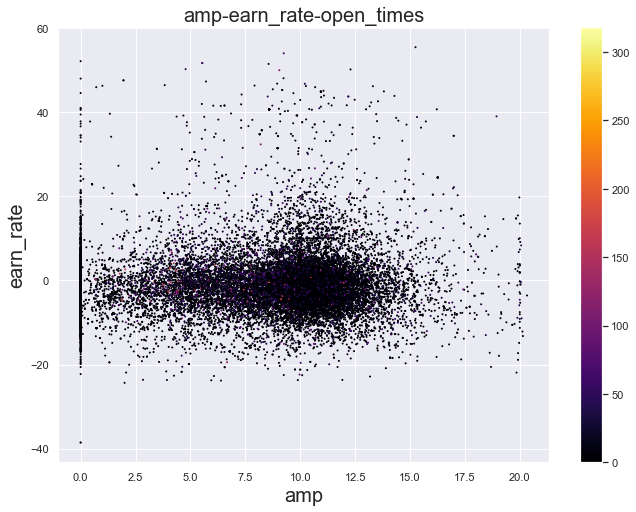

In [164]:
# from mylab.pdplot.myplot import *
myScatter(all_df, col1 = "amp", col2 = "earn_rate", color = "open_times", save_dir = "./temp/")
# plt.ylim(-10.5,10.5)
# plt.xlim(-0.1,8.1)

In [162]:
temp_df = all_df.loc[all_df.open_times.values == 4,:] 
# temp_df = temp_df.loc[temp_df.postday_open_pct.values > -5,:] 
# temp_df = temp_df.loc[temp_df.preday_pct_chg.values < 9,:] 
temp_df = temp_df.dropna(axis=0,subset = ["earn_rate"]) 
np.mean(temp_df.earn_rate.values)

-0.37937653119954634

In [139]:
temp_df.shape[0]/all_df.shape[0]

0.010769397564236926

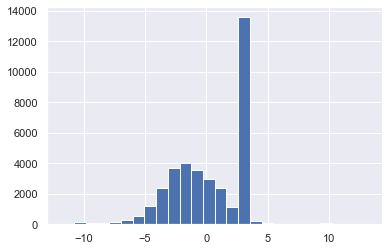

In [24]:
all_df.earn_rate.hist(bins = 26)

In [84]:
np.mean(all_df.postday_high_pst.values>1)

0.5516047228206037

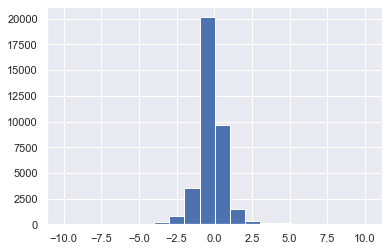

In [85]:
all_df.postday_open_pst.hist(bins = 20)

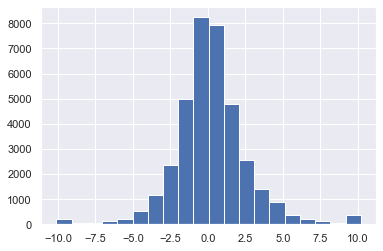

In [78]:
all_df.postday_close_pst.hist(bins = 20)

In [39]:

data_df = all_df.groupby('hold_period').agg({"earn_rate":np.mean,"earn_rate_per_day":np.mean,"win":np.mean})
data_df

,earn_rate,earn_rate_per_day,win
hold_period,,,
1.0,0.295713,0.295713,0.540890
2.0,0.160851,0.080425,0.527089
3.0,0.115335,0.038445,0.522478
4.0,0.035486,0.008871,0.512170


In [31]:
# 
temp_df = all_df.loc[all_df.hold_period.values ==1,:] 
temp_df.shape

(6861, 93)

In [93]:
1+reduce(lambda x, y: x+y, data_df.earn_rate_per_day.values[:]/100)

0.018684503612895642

(1046, 3)


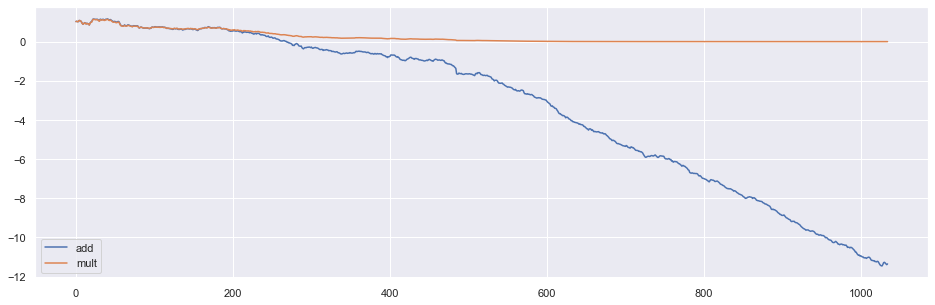

In [44]:
from functools import reduce  
# temp_df = all_df.loc[all_df.hold_period.values !=1,:] 
data_df = all_df.groupby('trade_date').agg({"earn_rate":np.mean,"earn_rate_per_day":np.mean})
data_df["earn_rate_add1"] = (data_df["earn_rate_per_day"]+100)/100
# data_df["earn_rate_acc"]
a = [1+reduce(lambda x, y: x+y, data_df.earn_rate_per_day.values[:i+1]/100) for i in range(len(data_df))] # len(data_df)
b = [reduce(lambda x, y: x*y, data_df.earn_rate_add1.values[:i+1]) for i in range(len(data_df))] # len(data_df)
print(data_df.shape)
plt.figure(figsize=(16,5))
plt.plot(a)
plt.plot(b)
plt.legend(["add","mult"])
plt.show()

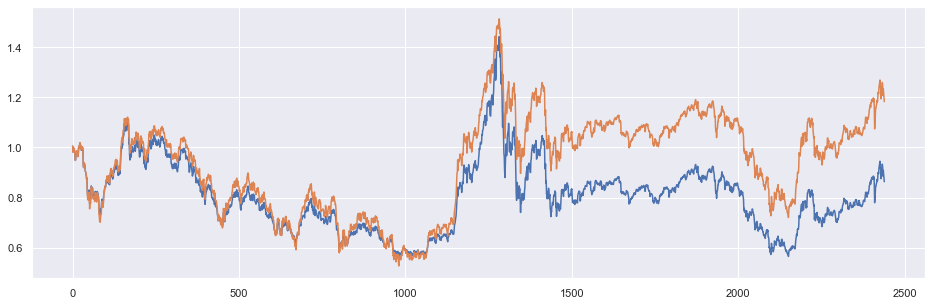

In [57]:
from mylab.stock.myread import getIndexDaily
index_df = getIndexDaily("399001.SZ", "20100303")
index_df["pct_chg_add1"] = (index_df["pct_chg"]+100)/100
b = [reduce(lambda x, y: x*y, index_df.pct_chg_add1.values[:i+1]) for i in range(len(index_df))] # len(data_df)
a = [1+reduce(lambda x, y: x+y, index_df.pct_chg.values[:i+1]/100) for i in range(len(index_df))] # len(data_df)
plt.figure(figsize=(16,5))
plt.plot(b)
plt.plot(a)

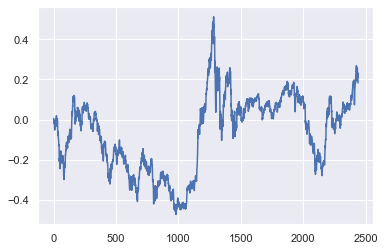

In [54]:
plt.plot(a)

In [38]:
index_df["pct_chg"].mean()

0.007478196721311477

In [ ]:
index_df = getIndexBasic()
index_df.head()